In [66]:
import string
from collections import Counter
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import math

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')  

stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)


In [69]:
def clean_phrase(phrase):
	"""clean_phrase funzione che rimuove le stopwords, segni di punteggiatura e numeri

	:param phrase: frase da pulire
	:return: frase pulita
	"""
	words = word_tokenize(phrase.lower())
	cleaned_words = [word for word in words if word.lower() not in stop_words and word not in punctuation and not word.isdigit() and word !="''"]
	return cleaned_words

def lexical_similarity_fun(block1,block2):
	"""lexical_similarity_fun funzione che calcola la cosine similarity tra due blocchi

	:block1: primo blocco di frasi da confrontare
	:block2: secondo blocco di frasi da confrontare
	:return: valore della cosine similarity tra due blocchi
	"""
	block1 = [clean_phrase(phrase) for phrase in block1]
	block2 = [clean_phrase(phrase) for phrase in block2]
	block1_merged= [word for sublist in block1 for word in sublist]
	block2_merged= [word for sublist in block2 for word in sublist]
	block1_dict = Counter(block1_merged)
	block2_dict = Counter(block2_merged)
	words = list(block1_dict.keys() | block2_dict.keys())
	numerator=0
	denominator_1=0
	denominator_2=0
	for word in words:
		numerator+=block1_dict[word]*block2_dict[word]
		denominator_1 += block1_dict[word]**2  
		denominator_2 += block2_dict[word]**2
	cos_sim=numerator / math.sqrt(denominator_1 * denominator_2)
	return cos_sim

def semantic_similarity_fun(block1, block2):
	""" semantic_similarity_fun funzione che effettua gli embedding dei due blocchi ne calcola la similarità

	:block1: primo blocco di frasi da confrontare
	:block2: secondo blocco di frasi da confrontare
	:return: valore medio del dot product tra i due blocchi (dot average)
	"""

	embeddings1 = model.encode(block1)
	embeddings2 = model.encode(block2)
	similarities = np.dot(embeddings1, np.transpose(embeddings2))
	similarity = np.max(similarities)
	
	return similarity   


def find_section_start_indices(text):
	"""find_section_start_indices funzione che trova tutte le occorrenze di '<SECTION_SEP>' in un documento
 
	:text: testo del documento da analizzare
	:return: gli indici che indicano i tagli corretti all'interno di un documento
	"""  
	sections=text.split('<SECTION_SEP>')
	boundaries=[]
	count=1
	for sec in sections[:-1]:
		sentences=sec.split('<SENTENCE_SEP>')[:-1]
		count+=len(sentences)
		boundaries.append(count)
	return boundaries


def plot_similiraty(graph,similarity,smoothed_similarities,actual_boundaries,predicted_boundaries,block_len,name_tag):
	"""
	plot_similiraty funzione che mostra i risultati ottenuti sotto forma di grafo
	:graph: 
	:similarity: valori di similarità ottenuto
	:smoothed_similarities: valori di similarità ottenuto smoothed
	:actual_boundaries: tagli attesi nel documento
	:predicted_boundaries: tagli calcolati tramite la lexical o semantic similarity
	:block_len: numero di frasi contenute in un blocco
	:name_tag: titolo del grafico
	:return: -
	""" 
	xpoints = np.arange(1,(len(smoothed_similarities)*block_len)+1,block_len)
	ypoints = similarity
	xpoints_smooth = np.arange(1,(len(smoothed_similarities)*block_len)+1,block_len)
	ypoints_smooth = smoothed_similarities
	graph.plot(xpoints, ypoints, '-o', color='red', label='Similarities')
	graph.plot(xpoints_smooth, ypoints_smooth, '-o', color='blue', label='Smoothed similarities')
	graph.set_title(name_tag) 

					
	for a_b in actual_boundaries:
		graph.axvline(x=(a_b-1), color='green', label='Actual boundaries')

	
	for p_d in predicted_boundaries:
		if p_d not in actual_boundaries:
			graph.axvline(x=(p_d-1), color='magenta', label='Predicted boundaries')
		else:
			graph.axvline(x=(p_d-1), color='black', label='Matched boundaries')


def get_boundaries(similarities,block_len,SECTION_SENS):
	"""
	get_boundaries funzione che, dati gli score di similarità, trova i tagli secondo la formula  (y_a_{i-1} - y_a_{i}) + (y_a_{i+1} - y_a_{i})
	:similarities: vettore contenete gli score di similarità relativi ad un documento
	:block_len: numero di frasi contenute in un blocco
	:SECTION_SENS: valore che regola come un depthscore venga calcolato come boundary (mean-std/SECTION_SENS)
	:return: una lista contenente tutti i tagli effettuati su un dato documento
	"""  
	depth_score_sim=[]
	for i in range(1,len(similarities)-1):
		score=(similarities[i-1]-similarities[i])+(similarities[i+1]-similarities[i])
		depth_score_sim.append(score)
	depth_score_sim.insert(0,similarities[1]-similarities[0])
	depth_score_sim.append(similarities[-2]-similarities[-1])

	filtered=list(filter(lambda x: x > 0, depth_score_sim))
	std=np.std(filtered)
	mean=np.mean(filtered)
	threshold=(mean-(std/SECTION_SENS))

	boundaries= [i for i, v in enumerate(depth_score_sim) if v > threshold]
	boundaries = [(x*block_len)+2 for x in boundaries]
	return boundaries

def boundaries_error(actual,predicted):
	"""
	boundaries_error: funzione che calcola il numero di tagli applicati male all'interno di un documento
	:actual: tagli attesi nel documento
	:predicted: tagli calcolati tramite la cosine similarities o il dot product
	:return: il numero di tagli sbagliati in un documento
	"""
	errors=[]
	for boundary in actual:
		min_edit_distance=6000
		for pr in predicted:
			edit_distance=abs(boundary-pr)
			if(edit_distance<min_edit_distance):
				min_edit_distance=edit_distance
		errors.append(min_edit_distance)
	return sum(errors)

def extrack_blocks(N_BLOCK, doc):
	"""
	extrack_blocks: funzione che crea i blocchi, ciascuno dei quali conterrà N_BLOCK frasi
	:N_BLOCK: tagli attesi nel documento
	:doc: documento dal quale creare i blocchi
	:return: lista contenente i blocchi appena creati
	"""
  
	blocks = []
	for i in range(0, len(doc), N_BLOCK):
		if i + (N_BLOCK-1) < len(doc):
			blocks.append(doc[i:i + N_BLOCK])
		else:
			blocks.append(doc[i:])
	return blocks





In [70]:


#contiene i documenti
df = pd.read_csv("data\\wiki_definitions.csv")  
docs=df["definitions"].astype(str).tolist()
doc_names=df["names"].astype(str).tolist()


#contiene, per ogni documento, gli indici dei separatori di paragrafo (in base alla frase)
docs_sections=[]
for doc in docs:
    sections_pos=find_section_start_indices(doc)
    docs_sections.append(sections_pos)


#contiene i documenti, ma separati frase per frase
docs_sent_by_sent=[]
for doc in docs:
    doc_t=doc.replace('<SECTION_SEP>','')
    doc_t=doc_t.replace('\r', '').replace('\n', '')
    doc_splitted=doc_t.split('<SENTENCE_SEP>')
    docs_sent_by_sent.append(doc_splitted)



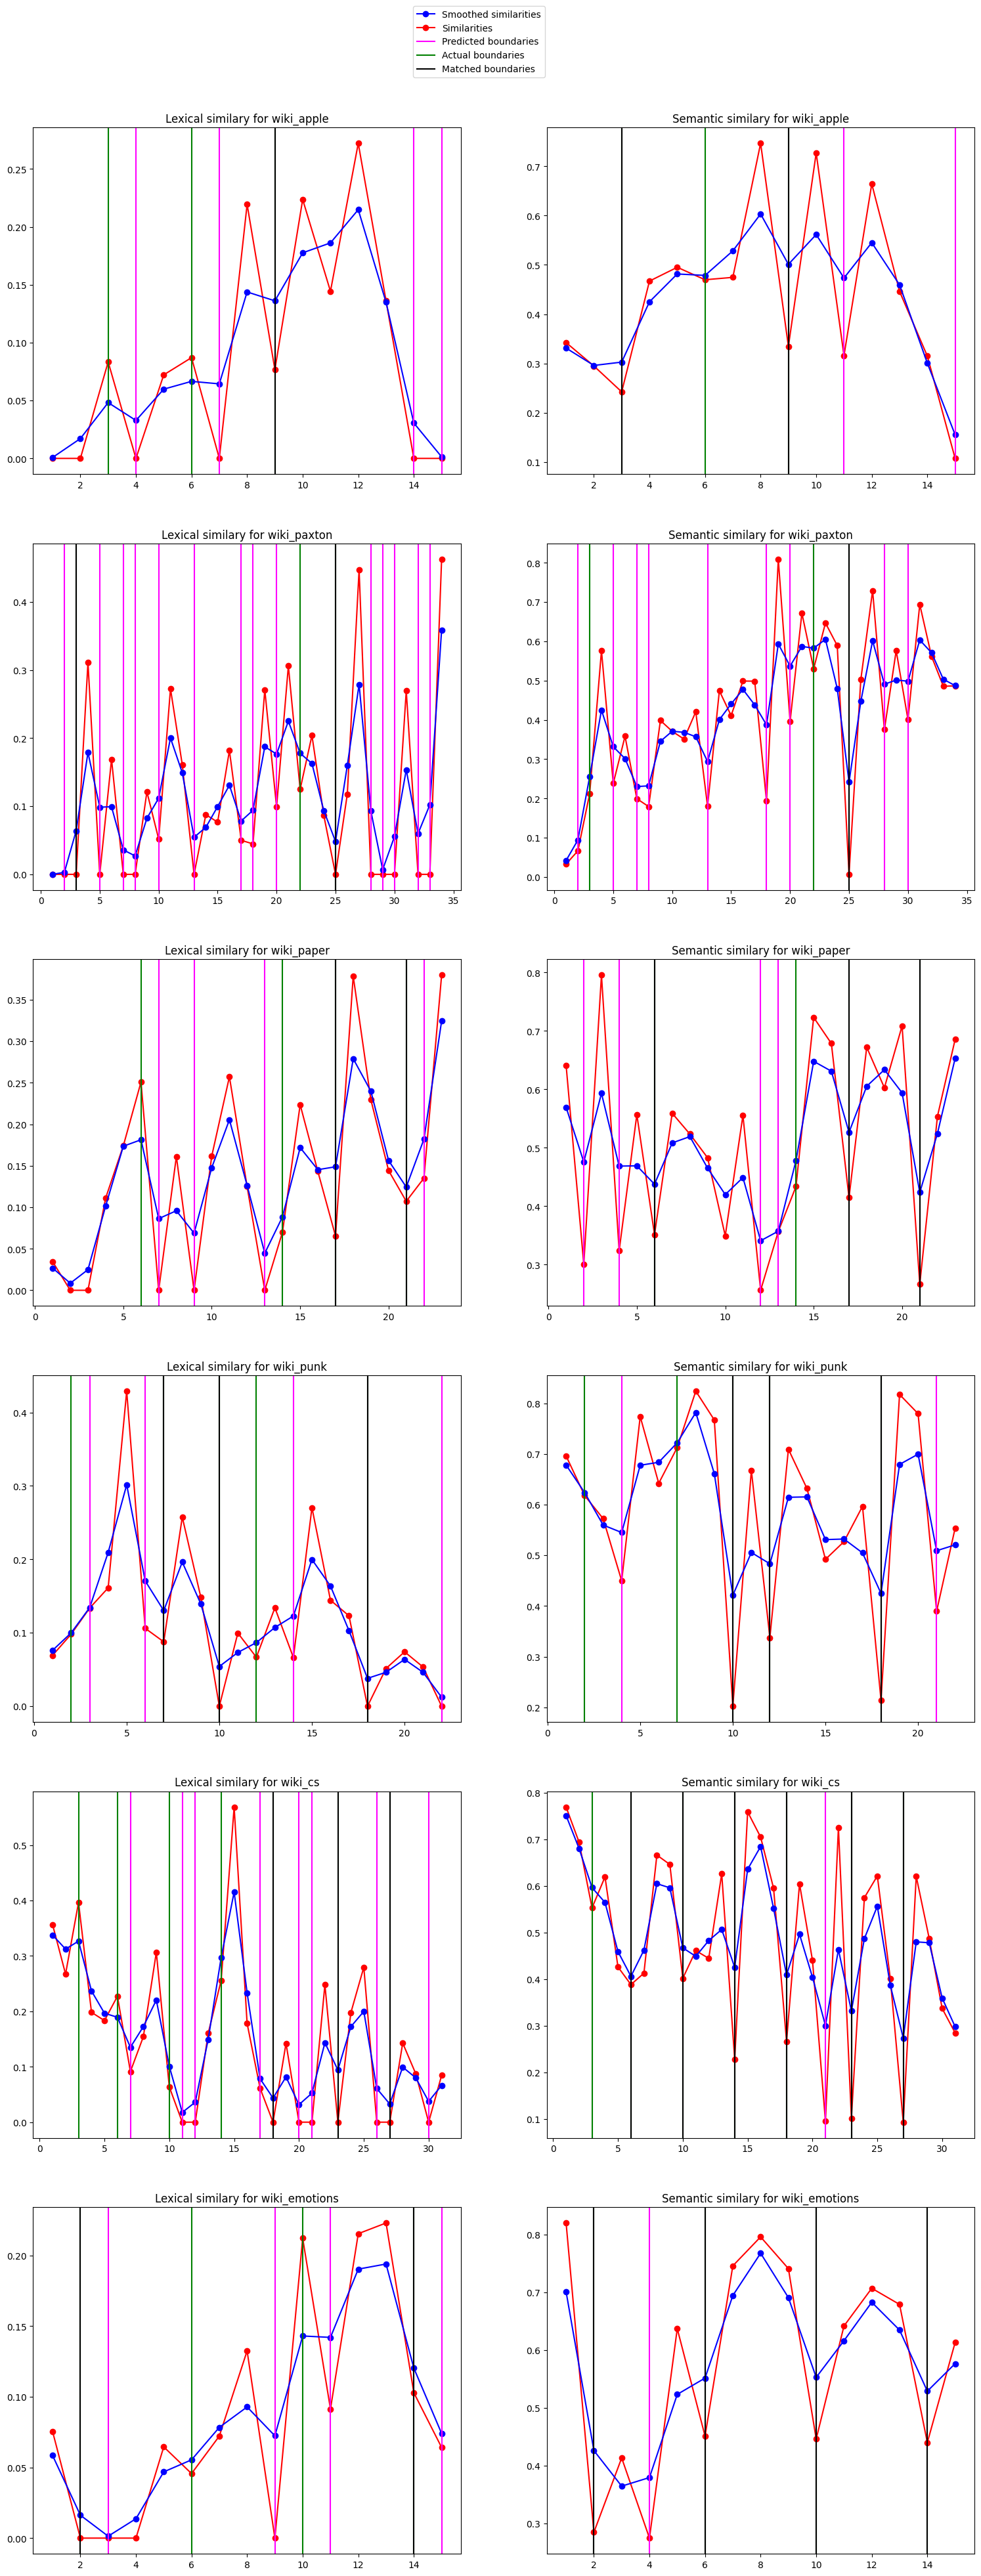

In [79]:
#Numero di frasi contenute in ogni blocco
N_BLOCK=1
#Valore che regola il livello di smoothing del similarity score
SMOOTH=0.7
#Valore che regola se un depthscore venga considerato come boundary o meno (mean-std/SECTION_SENS)
SECTION_SENS=2

#Genera (len(docs))*2 sotto grafici
figure, axis = plt.subplots(len(docs), 2) 
figure.set_size_inches(18.5, 8*(len(docs)))


boundaries_list=[]
boundaries_error_list=[]

for DOC_NUM in range(0,len(docs)):

    doc=docs_sent_by_sent[DOC_NUM]
    blocks = extrack_blocks(N_BLOCK, doc)

    #Calcola la similarità per ciascun blocco
    lexical_similarities=[]
    transformer_similarities=[]
    for i in range(0,len(blocks)-1):

        lex_similarity=lexical_similarity_fun(blocks[i],blocks[i+1])
        lexical_similarities.append(lex_similarity)
        bert_similarity=semantic_similarity_fun(blocks[i],blocks[i+1])
        transformer_similarities.append(bert_similarity)

    #Applica il filtro gaussiano agli score di similarità
    smoothed_lexical_similarities=gaussian_filter1d(lexical_similarities, sigma=SMOOTH)
    smoothed_transformer_similarities=gaussian_filter1d(transformer_similarities, sigma=SMOOTH)

    #Estrai i tagli e calcola l'errore per la similarità lessicale 
    boundaries_lex=get_boundaries(smoothed_lexical_similarities,N_BLOCK,SECTION_SENS)
    boundaries_error_lex=boundaries_error(docs_sections[DOC_NUM],boundaries_lex)

    #Estrai i tagli e calcola l'errore per la similarità semantica
    boundaries_emb=get_boundaries(smoothed_transformer_similarities,N_BLOCK,SECTION_SENS)
    boundaries_error_emb=boundaries_error(docs_sections[DOC_NUM],boundaries_emb)

    #Salva i risultati come tuple (lexical output, semantic output)
    boundaries_list.append((boundaries_lex,boundaries_emb))
    boundaries_error_list.append((boundaries_error_lex,boundaries_error_emb))

    #Visualizza i risultati in due grafi per ciascun approccio
    plot_similiraty(axis[DOC_NUM][0],lexical_similarities,smoothed_lexical_similarities,docs_sections[DOC_NUM],boundaries_lex,N_BLOCK,name_tag="Lexical similary for "+doc_names[DOC_NUM])
    plot_similiraty(axis[DOC_NUM][1],transformer_similarities,smoothed_transformer_similarities,docs_sections[DOC_NUM],boundaries_emb,N_BLOCK,name_tag="Semantic similary for "+doc_names[DOC_NUM])
    

legend_handles, labels = axis[4][1].get_legend_handles_labels()
label_to_handle = dict(zip(labels, legend_handles))
unique_labels = set(labels)
filtered_handles = []
for label in unique_labels:
    if label in label_to_handle:
        filtered_handles.append(label_to_handle[label])
figure.legend(filtered_handles, list(unique_labels),bbox_to_anchor=(0.55,0.92))
plt.show()

In [77]:


errors = {'document': ['apple','paxton', 'paper', 'punk','computer science','emotions'], 
          'lexical_match_error': [i[0] for i in boundaries_error_list],
          'semantic_match_error':  [i[1] for i in boundaries_error_list],
          'lexical_number_of_section_error':  [abs(len(boundaries_list[i][0])-len(docs_sections[i])) for i in range(0,len(docs))] ,
          'semantic_number_of_section_error':  [abs(len(boundaries_list[i][1])-len(docs_sections[i])) for i in range(0,len(docs))] 
          }

pd_errors=pd.DataFrame(errors)
total= pd_errors.sum(numeric_only=True, axis=0)
pd_errors.loc[len(pd_errors.index)] = ['TOTAL', total['lexical_match_error'], total['semantic_match_error'],total['lexical_number_of_section_error'],total['semantic_number_of_section_error']] 

display(pd_errors)

print("Lexical (match+section) error " + str(total['lexical_match_error']+total['lexical_number_of_section_error']))
print("Semantinc (match+section) error " + str(total['semantic_match_error']+total['semantic_number_of_section_error']))


boundaries_to_pd = {'document': ['apple','paxton', 'paper', 'punk','computer science','emotions'], 'lexical_predicted_boundaries': [i[0] for i in boundaries_list],'semantic_predicted_boundaries':  [i[1] for i in boundaries_list],'real_boundaries':  docs_sections}
display(pd.DataFrame(boundaries_to_pd))



,document,lexical_match_error,semantic_match_error,lexical_number_of_section_error,semantic_number_of_section_error
0,apple,2,1,2,2
1,paxton,0,0,11,7
2,paper,2,2,3,3
3,punk,2,5,2,0
4,computer science,2,11,7,1
5,emotions,3,4,1,0
6,TOTAL,11,23,26,13


Lexical (match+section) error 37
Semantinc (match+section) error 36


,document,lexical_predicted_boundaries,semantic_predicted_boundaries,real_boundaries
0,apple,"[5, 8, 10, 12, 15]","[4, 8, 10, 12, 16]","[4, 7, 10]"
1,paxton,"[4, 6, 8, 11, 14, 19, 21, 23, 26, 27, 29, 31, ...","[4, 6, 9, 14, 19, 21, 23, 26, 29, 31]","[4, 23, 26]"
2,paper,"[4, 8, 10, 14, 15, 18, 23]","[3, 5, 7, 11, 13, 18, 22]","[7, 15, 18, 22]"
3,punk,"[5, 7, 8, 11, 13, 15, 19]","[5, 11, 13, 19, 22]","[3, 8, 11, 13, 19]"
4,computer science,"[3, 5, 8, 11, 13, 15, 17, 19, 21, 22, 24, 27, ...","[11, 15, 19, 22, 24, 28]","[4, 7, 11, 15, 19, 24, 28]"
5,emotions,"[3, 5, 10, 12, 15]","[3, 5, 7, 11]","[3, 7, 11, 15]"
